In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [161]:
import yaml

class parse(object):
    def __init__(self, path):
        with open(path, 'r') as file:
            self.parameters = yaml.safe_load(file)

    def __getitem__(self, key):
        return self.parameters[key]

    def save(self, filename):
        with open(filename, 'w') as f:
            yaml.dump(self.parameters, f)
param = parse('./config/test.yaml')

In [315]:
# class neuron:
#     def __init__(self, init_params):
#         self.time_steps = init_params['time_steps']
#         self.membrane = np.zeros(self.time_steps)
#         self.spike_train = np.zeros(self.time_steps)
#         self.threshold = init_params['threshold']
#         if init_params['func_type'] == 'exp':
#             self.rho_0 = 1/np.exp(self.threshold)

class recurrent_network:
    def __init__(self, init_params):
        self.dtype = np.float32
        self.time_steps = init_params['time_steps']
        self.neuron_num = init_params['neuron_num']
        self.threshold = init_params['threshold']
        if init_params['func_type'] == 'exp':
            self.delta_mem = init_params['delta_mem']
            self.rho_0 = 1
        self.weight_matrix = np.random.normal(size=(self.neuron_num, self.neuron_num)).astype(self.dtype)*0.3
        row, col = np.diag_indices_from(self.weight_matrix)
        self.weight_matrix[row,col] = -self.threshold
        self.input_weight = np.random.normal(size=(self.neuron_num)).astype(self.dtype)*0.3
        self.membrane_potentials = np.zeros((self.neuron_num, self.time_steps), dtype=self.dtype)
        self.firing_rate = np.zeros((self.neuron_num, self.time_steps), dtype=self.dtype)
        self.spike_train = np.zeros((self.neuron_num, self.time_steps), dtype=np.int8)
        self.input = np.random.normal(size=(self.neuron_num, self.time_steps)).astype(self.dtype)*0.1
        self.psc = np.zeros((self.neuron_num, self.time_steps), dtype=self.dtype)
        self.tau_mem = init_params['tau_mem']
        self.mem_decay = 1 - 1/self.tau_mem
        self.tau_psc = init_params['tau_psc']
        self.psc_decay = 1 - 1/self.tau_psc
    def plot(self):
        fsize = 15
        size_factor = 0.06
        total_plots = 5
        name_list = ['membrane_potentials','firing_rate','spike_train','input','psc']
        value_list = [self.membrane_potentials,np.clip(self.firing_rate,0,3),self.spike_train,self.input,self.psc]
        plt.figure(figsize=(30,3))
#         plt.subplot(1,6,1)
        plt.imshow(self.weight_matrix)
        plt.title('weight_matrix', fontsize = fsize)
        for i in range(total_plots):
            plt.figure(figsize=(self.time_steps*size_factor, self.neuron_num*size_factor))
#             plt.subplot(1,6,i+2)
            plt.imshow(value_list[i])
            plt.title(name_list[i], fontsize = fsize)
    def forward(self):
        temp_mem = np.zeros(a.neuron_num)
        temp_psc = np.zeros(a.neuron_num)
        for t in range(self.time_steps):
            temp_mem = temp_mem*self.mem_decay + np.matmul(self.input[:,t].T,self.input_weight) + np.matmul(temp_psc.T, self.weight_matrix)
            self.membrane_potentials[:,t] = temp_mem.copy()
            self.firing_rate[:,t] = self.rho_0 * np.exp((self.membrane_potentials[:,t]-self.threshold)/self.delta_mem)
            prob = np.random.uniform(size=self.neuron_num)
            self.spike_train[:,t] = (self.firing_rate[:,t] > prob)
            self.psc[:,t] = temp_psc * self.psc_decay + 1/self.tau_psc * self.spike_train[:,t]
            temp_psc = self.psc[:,t]
    def STDP(self):
        self.weight_update = np.ones(shape=(20,20),dtype=np.float32)
        window_length = 5
        window_t = np.arange(-window_length,window_length+1,1)
        STDP_func = 0.42*np.exp(-window_t**2/(10))*(np.sign(window_t)+0.5)
        STDP_repete = np.empty((self.neuron_num,2*window_length+1),dtype=np.float32)
        STDP_repete[:]=STDP_func
        pad_spikes = np.pad(self.spike_train,((0,0),(window_length,window_length)),'constant')
        for i in range(self.time_steps):
            updates = 1 + pad_spikes[:,i:i+11] * STDP_repete
            start_index = np.where(pad_spikes[:,i+5]==1)
            updates = np.prod(updates,axis=1)
            end_index = np.where(updates!=1)
            self.weight_update[np.ix_(start_index[0],end_index[0])]*=updates[end_index]
        row, col = np.diag_indices_from(self.weight_update)
        self.weight_update[row,col] = 1.
        self.weight_matrix*=self.weight_update
    def STDP_plot(self):
        plt.figure(figsize=(7,3))
        plt.subplot(1,2,1)
        plt.imshow(self.weight_matrix)
        plt.title('new weight matrix')
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(self.weight_update)
        plt.title('weight updating signal')
        plt.colorbar()


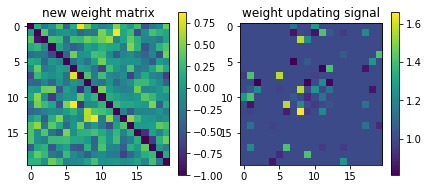

In [316]:
a = recurrent_network(param)

a.forward()
# a.plot()
a.STDP()
a.STDP_plot()

<Figure size 432x432 with 0 Axes>

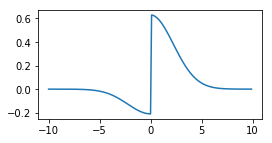

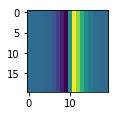

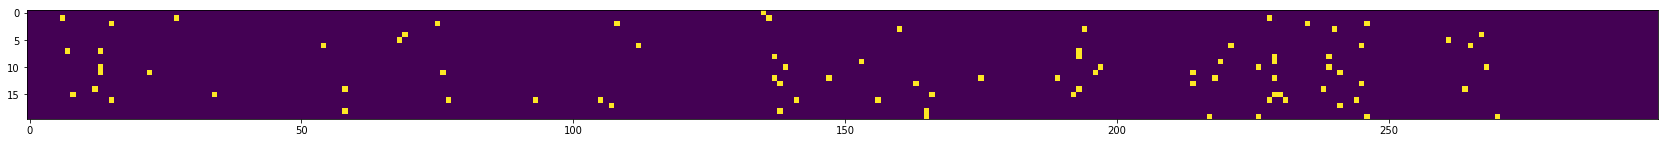

In [235]:
x = np.arange(-10,10,0.1)
y = 0.42*np.exp(-x**2/(10))*(np.sign(x)+0.5)
plt.figure(figsize=(6,6))
plt.figure(figsize=(4,2))
plt.plot(x,y)

x = np.arange(-10,10,1)
y = np.exp(-x**2/(10))*(np.sign(x)+0.3)
z = np.empty((20,20),dtype=np.float32)
z[:]=y
plt.figure(figsize=(1.5,1.5))
plt.imshow(z)

plt.figure(figsize=(30,2))
plt.imshow(a.spike_train)


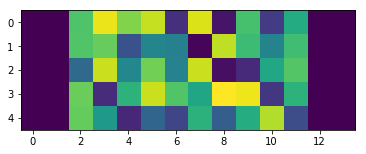

In [243]:
plt.imshow(np.pad(np.random.random((5,10)),((0,0),(2,2)),'constant'))

In [245]:
p = np.array([[1,2,3],[4,5,6],[7,8,9]])
p[1:,1:]

array([[5, 6],
       [8, 9]])

In [284]:
print((start_index)[0])

[ 7  8 14]


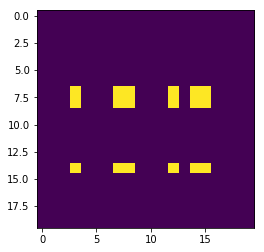

In [287]:
weight_update[np.ix_(start_index[0],end_index[0])]
plt.imshow(weight_update)

[0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]
(array([ 7,  8, 14]),)
(array([ 3,  7,  8, 12, 14, 15]),)
[1.         1.         1.         1.1271948  1.         1.
 1.         1.2561389  1.2561389  1.         1.         1.
 0.80998415 1.         1.2561389  1.4223017  1.         1.
 1.         1.        ]
(6,)


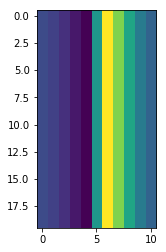

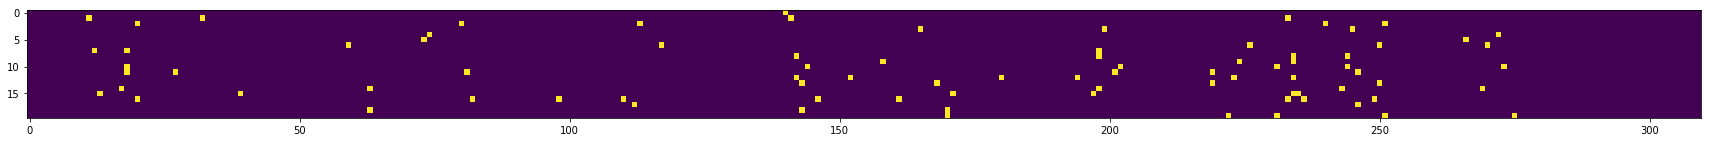

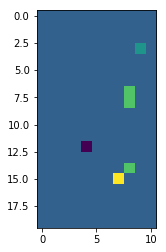

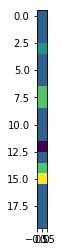

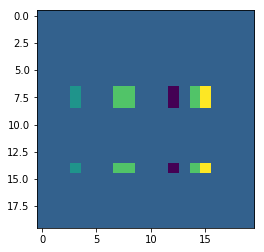

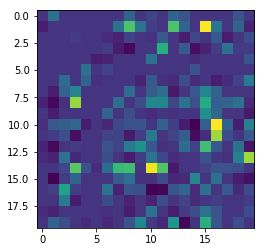

In [298]:
weight_update = np.ones(shape=(20,20),dtype=np.float32)
x = np.arange(-5,6,1)
y = 0.42*np.exp(-x**2/(10))*(np.sign(x)+0.5)
z = np.empty((20,11),dtype=np.float32)
z[:]=y
plt.imshow(z)
pad_spikes = np.pad(a.spike_train,((0,0),(5,5)),'constant')
plt.figure(figsize=(30,2))
plt.imshow(pad_spikes)
plt.figure()
# print(np.shape(pad_spikes[:,0:0+11]))
kkk = 1+z*pad_spikes[:,190:190+11]
plt.imshow(1+z*pad_spikes[:,190:190+11])
start_index = np.where(pad_spikes[:,198]==1)

print(pad_spikes[:,198])
print(start_index)
p = np.prod(kkk,axis=1)

end_index = np.where(p!=1)
print(end_index)

# print(weight_update[start_index,:][:,end_index])
plt.figure()
plt.imshow(np.array([p]).T)
print(p)

weight_update[np.ix_(start_index[0],end_index[0])]*=p[end_index]
# print(weight_update)
plt.figure()
plt.imshow(weight_update)
print(np.shape(p[end_index]))
for i in range(a.time_steps):
    updates = 1 + pad_spikes[:,i:i+11] * z
    start_index = np.where(pad_spikes[:,i+5]==1)
    updates = np.prod(updates,axis=1)
    end_index = np.where(updates!=1)
    weight_update[np.ix_(start_index[0],end_index[0])]*=updates[end_index]
row, col = np.diag_indices_from(weight_update)
weight_update[row,col] = 1.
plt.figure()
plt.imshow(weight_update)

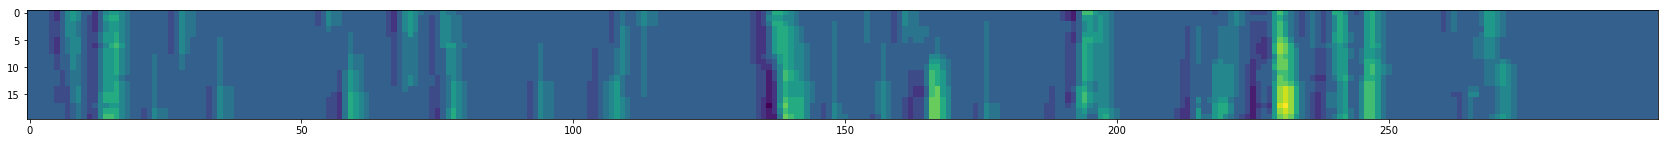

In [229]:
weight_update = np.zeros(shape=(20,20),dtype=np.float32)
# plt.imshow(weight_update)
from scipy import ndimage
c = ndimage.convolve(a.spike_train, z)
plt.figure(figsize=(30,2))
plt.imshow(c)
# for i in range(a.time_steps):
    

0.9999821594038415

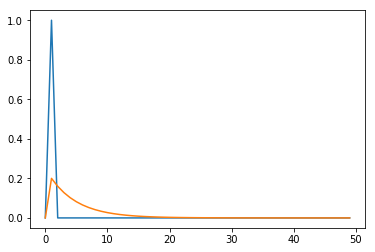

In [52]:
spike_train = np.zeros(50)
spike_train[1] = 1
psc = np.zeros(50)

integ = np.zeros(50)
tau = 5
decay = 1-1/5

temp = 0
for i in range(50):
    psc[i] = temp * decay + spike_train[i] * (1/5)
    temp = psc[i]
plt.plot(spike_train)
plt.plot(psc)
np.sum(psc)

